In [1]:
from IPython.display import HTML
from IPython.display import display

import numpy as np
from math import *
from numba import njit
np.set_printoptions(linewidth=np.inf)

from matplotlib import pyplot as plt
#%matplotlib notebook

# Simulation of Pseudo-random Planetary Systems

This is the primary notebook for generating Planetary systems, with variying paramters for each iteration of simulation.  This is in part the **distribution of mass**, the **initial distances** for bodies in orbit around a central star and the **abundance** of these bodies.

----------------------

The first part of this notebook, will go over the generation of pseudorandom parameters for each group of bodies in the system. Where the groups are sequentially the central star, the inner planets and the outer planets. The definitions of these groups, are linked to specific intervals, derived in the Bachelor project this notebook is attached to. We will however note that these values can be arbitrary, although we do not recommend changing these values much more than those found in real planetary systems, as that would most likely lead to non-stable orbiting systems.


The initial statements for each group are arranged into three-dimentional arrays. From this it is possible to calculate the gravitational force on the *i'th* body from every other body in the system, for every timestep. Which in turn makes it possible to determine the acceleration value of each body.

Given the initial statements of the system, it is possible to calculate the following values for the time, position and velocity a time step later by applying the *Leap-Frog method*. 

Thus the general data which can be optained from this simualtion is in the form of three-dimentional arrays, of the positions, velocities, accelerations and forces of each body at each timestep.

-----------

*We encourage the reader to look at the code and accompanying explinations for the best utilization of the data generated.*

### Physical  constants

First and foremost, some general physical constants are defined and scaled to astronomical size. These constants are used in later equations. 

We have the gravitational constant `G` which is in units of $\text{AU}^{3} \text{solarmasses}^{-1} \text{years}^{-2}$. Next we have one solar mass `M` in the units of kilograms.

In [2]:
G = 39.47970417034628
M = 1.98855e30 

###  Structure of the System

We start by determining the number of bodies `num_bodies` that will be in the system. This is done by executing the first command `np.int(np.random.uniform())` which will return a random integer between 3 and 5. Next we define the number of dimensions the system will have and set that to three.

--------------

For our groups we need to define some values. We deine a number of arrays of zeroes for respectively the position, velocity, acceleration, force and mass. We also had to write up some arrays which hold some of the initial properties of system - the initial velocity `init_vel`, perihelion distance `rp`, aphelion distance `ra`, semi-major axis `a` and eccintricity `e`. This is to place our simulated data into.

In [3]:
num_bodies = np.int(np.random.uniform(3,6,1))
#num_bodies = 5
dimension  = 3

# Main Arrays
pos   = np.zeros((num_bodies, dimension))
vel   = np.zeros((num_bodies, dimension))
acc   = np.zeros((num_bodies, dimension))
force = np.zeros((num_bodies, dimension))
mass  = np.zeros((num_bodies))

# Initial Properties
init_vel = np.zeros((num_bodies))
r_pe     = np.zeros((num_bodies))
r_ap     = np.zeros((num_bodies))
a        = np.zeros((num_bodies))
e        = np.zeros((num_bodies))

# Arrays for plotting
inpos = np.zeros((num_bodies, dimension))
invel = np.zeros((num_bodies, dimension))

### Assigning values for the mass

We define our 0'th element in our array `mass` to be our central star. We assign a random value between $\texttt{1.5e30/M}$ and $\texttt{2.5e30/M}$. From the 1'st to the 3'rd element in the same array, we define the masse of the inner planets a random value between $\texttt{3e23/M}$ and $\texttt{6e24/M}$. Lastly from the 4'th element and onwards in the array, we define the masses of the outer planets to a random value between $\texttt{10e25/M}$ and $\texttt{6e26/M}$.

This step is pretty straight forward, and we can print `mass` to see our array of values.

In [4]:
# Central Star
mass[0] = np.random.uniform(1.5e30/M, 2.5e30/M, 1)

# Inner Planets
mass[1:] = np.random.uniform(3e23/M, 6e24/M, num_bodies-1)

# Outer Planets
mass[3:] = np.random.uniform(10e25/M, 6e26/M, num_bodies-3)

print('masses:')
print(mass)

masses:
[1.12729964e+00 2.23700406e-06 8.25185149e-07 9.87483428e-05]


### Assigning values for the distances and calculating the initial velocities

One of the assumptions for our system is that the central star (the 0'th element) is located at zero, i.e. we don't need to assign some distance value for it. 

Thus we start by creating a loop which assigns a perihelion and aphelion distance in the range of $\texttt{0.5}$ to $\texttt{1.5}$ for elements $\texttt{1}$ to $\texttt{2}$ in the arrays `r_pe` and `r_ap` respectively. The aphelion distances needs to be larger by definition, thus we define it as the perihelion plus some small number. These distances are for the group of inner planets. These steps are fundamentally the same for the outer planets, although we only look at elemets which are $m\leq3$.

Next one has to determine the initial velocities for the elemets at the assigned distances. Much like for the distances, we also assume that the central star has zero initial velocity, i.e we start from the 1'st element. We place these values into both our `pos` and `vel` arrays - note we place each planet at their perihelion distances, noted as `r_pe`.

Lastly we need to minus the velocity of the center of mass for the system, on each element in the system. This is done on the line `CM_vel_x = np.sum((vel[:,0]*mass))/np.sum(mass)`.

In [5]:
# Inner Planets
for m in range(1,num_bodies):
    r_pe[m] = np.random.uniform(0.7, 1.8, 1)
    if m>1:
        r_pe[m] = r_pe[m]+r_pe[m-1]
    r_ap[m] = r_pe[m]+np.random.uniform(0,0.2,1)

    
# Outer Planets 
for m in range(3,num_bodies):
    r_pe[m] = np.random.uniform(6, 9, 1) 
    if m>3:
        r_pe[m] = r_pe[m]+r_pe[m-1]
    r_ap[m] = r_pe[m]+np.random.uniform(1,1.5,1)


# Initial Velocities
for m in range(1,num_bodies):
    e[m] = np.random.uniform(0,0.05, 1) 
    a[m] = (r_pe[m] + r_ap[m])/2
    init_vel[m] = np.sqrt(((G*mass[0])/(a[m]))*((1+e[m])/(1-e[m])))
    

pos[:,1] = r_pe
vel[:,0] = init_vel


# Velocity of the Center of Mass
CM_vel_x = np.sum((vel[:,0]*mass))/np.sum(mass)
vel[:,0] = vel[:,0]-CM_vel_x

print('eccentricity:')
print(e)

eccentricity:
[0.         0.02060607 0.04609957 0.0295256 ]


### Plot of initial Positions

For visualization purposes, we can plot the initial positions of the bodies, at their randomly generated perihelion distances. We see that the central star is located at the position zero, and preceding planets are plotted along the x-axis. The code is not importent in itself, it is just for visualization purposes.

Text(0, 0.5, 'AU')

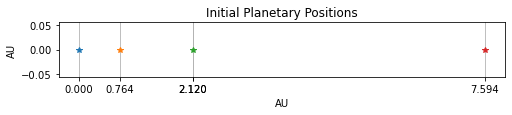

In [6]:
inpos[:,1] = r_pe
invel[:,0] = init_vel

plt.figure(figsize=(8, 1))
ax3 = plt.subplot(111)

ax3.plot(inpos[0,1],inpos[0,0],'*',)
ax3.plot(inpos[1,1],inpos[1,0],'*',)
ax3.plot(inpos[2,1],inpos[2,0],'*',)
if num_bodies > 3:
    ax3.plot(inpos[3,1],inpos[3,0],'*',)
    
if num_bodies > 4:
    ax3.plot(inpos[4,1],inpos[4,0],'*',)

ax3.set_title('Initial Planetary Positions')
x = [inpos[0,1], inpos[1,1], inpos[2,1]]
if num_bodies > 3:
    x = [inpos[0,1], inpos[1,1], inpos[2,1], inpos[2,1], inpos[3,1]] 

if num_bodies > 4:
    x = [inpos[0,1], inpos[1,1], inpos[2,1], inpos[2,1], inpos[3,1], inpos[4,1]]
    
plt.xticks(x)
plt.grid(axis='x', linestyle='-')

plt.xlabel("AU")
plt.ylabel("AU")

### Force Function

Next we have to define the force each body has on every other body in the system. To do this we define a function `grav_force` which has elements of position, mass and force. We define `num_bodies` and `D` to be the magnitudes of `pos`'s dimentions.

We make a loop where for the i'th element in `num_bodies` we define a three dimentional array of zeros. Then we can calculate the force on the i'th element from every other element. This is done by a loop where we look at the j'th element in `num_bodies` for which is not equal to i. From here it is possible to calculate `force[i]` from Newtons law of Universal Gravitation.

In [7]:
@njit
def grav_force(pos, mass, force): 
    num_bodies, D = pos.shape 
    for i in np.arange(num_bodies): 
        force[i] = np.zeros(D) 
        
        for j in np.arange(num_bodies):
            if j!=i:
                r_vec = pos[i]-pos[j]
                r_mag = np.linalg.norm(r_vec)
                r_hat = r_vec/r_mag
                force[i] += (-G*mass[i]*mass[j])/(r_mag**2)*r_hat

### Leapfrog Function

The next order of buisness is to define the Leapfrog function. This is the primary function , which will allow one to calculate the positions and velocities for each interacting body in the system. The setup mimics the same idea that we write upsome arrays for times, positions, velocities and accelerations. 

Next we calculatethe positions and velocities in a for loop using the equations from the Leapfrog method. A detailed explaination of the assumptions and setup of the Leapfrog method can be seen in the project assosiated with this code.

In [8]:
@njit
def leapfrog(pos, mass, vel, force, sim_time, dt, outsteps):
    num_steps = ceil((sim_time/dt)/outsteps)
    num_bodies, D = pos.shape

    times = np.zeros((num_steps))
    positions = np.zeros((num_steps, num_bodies, D))
    velocities = np.zeros((num_steps, num_bodies, D))
    accelerations = np.zeros((num_steps, num_bodies, D))
    time = 0
    
    for step in range(num_steps):
        for i in range(outsteps):
            time += dt
            grav_force(pos, mass, force)
            acc = (force.T/mass).T
            vel += acc*dt
            pos += vel*dt
        
        times[step] = time 
        positions[step] = pos
        velocities[step] = vel
        accelerations[step] = acc
    
    return times, positions, velocities, accelerations

In [9]:
times, positions, velocities, accelerations = leapfrog(pos, mass, vel, acc, 100, 1e-4, 10)

%time _ = leapfrog(pos, mass, vel, acc, 100, 1e-4, 10)

Wall time: 9.51 s


### Plot the Positions of the System
This code is for plotting the positions of the data - one can change the amount of time the simulation will have to run, in the cell above.

num_bodies: 4


Text(0, 0.5, 'AU')

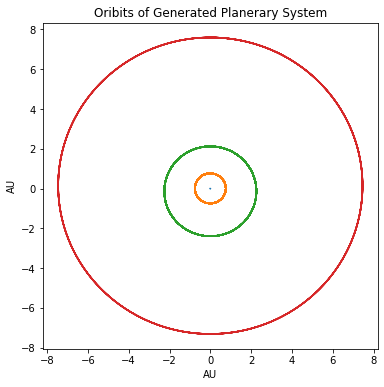

In [10]:
print('num_bodies:',num_bodies)

plt.figure(figsize=(6, 6))
plt.plot(positions[:,:,0],positions[:,:,1],'-')
plt.title('Oribits of Generated Planerary System')

plt.xlabel("AU")
plt.ylabel("AU")

### Save generated data

The following code saves the data. It is saved as "x" and an abbreviation of positions, velocities and acceleration, to wherever this file is located on ones computer.

In [11]:
xpos = np.array([positions[:,0,0],positions[:,0,1],positions[:,1,0],positions[:,1,1],positions[:,2,0],positions[:,2,1]])
xpos = xpos.T
xvel = np.array([velocities[:,0,0],velocities[:,0,1],velocities[:,1,0],velocities[:,1,1],velocities[:,2,0],velocities[:,2,1]])
xvel = xvel.T
xacc = np.array([accelerations[:,0,0],accelerations[:,0,1],accelerations[:,1,0],accelerations[:,1,1],accelerations[:,2,0],accelerations[:,2,1]])
xacc = xacc.T

if num_bodies > 3:
    xpos = np.array([positions[:,0,0],positions[:,0,1],positions[:,1,0],positions[:,1,1],positions[:,2,0],positions[:,2,1],positions[:,3,0],positions[:,3,1]])
    xpos = xpos.T
    xvel = np.array([velocities[:,0,0],velocities[:,0,1],velocities[:,1,0],velocities[:,1,1],velocities[:,2,0],velocities[:,2,1],velocities[:,3,0],velocities[:,3,1]])
    xvel = xvel.T
    xacc = np.array([accelerations[:,0,0],accelerations[:,0,1],accelerations[:,1,0],accelerations[:,1,1],accelerations[:,2,0],accelerations[:,2,1],accelerations[:,3,0],accelerations[:,3,1]])
    xacc = xacc.T

if num_bodies > 4:
    xpos = np.array([positions[:,0,0],positions[:,0,1],positions[:,1,0],positions[:,1,1],positions[:,2,0],positions[:,2,1],positions[:,3,0],positions[:,3,1],positions[:,4,0],positions[:,4,1]])
    xpos = xpos.T
    xvel = np.array([velocities[:,0,0],velocities[:,0,1],velocities[:,1,0],velocities[:,1,1],velocities[:,2,0],velocities[:,2,1],velocities[:,3,0],velocities[:,3,1],velocities[:,4,0],velocities[:,4,1]])
    xvel = xvel.T
    xacc = np.array([accelerations[:,0,0],accelerations[:,0,1],accelerations[:,1,0],accelerations[:,1,1],accelerations[:,2,0],accelerations[:,2,1],accelerations[:,3,0],accelerations[:,3,1],accelerations[:,4,0],accelerations[:,4,1]])
    xacc = xacc.T

np.save('xpos.npy', xpos)
np.save('xvel.npy', xvel)
np.save('xacc.npy', xacc)